In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import pylab
from torch import optim
from tqdm import tqdm_notebook
from models import VAE

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root = '/home/yanzy/SEU_NNFailure/CIFAR_10/data', train=True,
                                        download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='/home/yanzy/SEU_NNFailure/CIFAR_10/data', train=False,
                                       download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2, pin_memory=True)

device = torch.device('cuda:1')

def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap= plt.cm.gray)

# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
pylab.show()
print(images.max(),images.min())
print(images.shape)

<Figure size 640x480 with 1 Axes>

tensor(1.) tensor(0.)
torch.Size([16, 3, 32, 32])


In [2]:
model = VAE()
model.to(device)

reconstruction_function = nn.BCELoss(reduction = 'sum')
#reconstruction_function.size_average = False
loss_fn = torch.nn.MSELoss()


def loss_function(recon_x, x, mu, logvar, epoch):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    #if epoch < 50:
    #    return 1000 * BCE + KLD
    #else:
    #    return BCE + KLD
    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [3]:
def train(epoch):
    model.train()
    train_loss = 0
    total = 0
    Loader = tqdm_notebook(train_loader, leave = False)
    for data in Loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        #recon_batch = recon_batch.clamp(0,1)
        #recon_batch = (recon_batch - torch.min(recon_batch)) / (torch.max(recon_batch) - torch.min(recon_batch))
        loss = loss_function(recon_batch, inputs, mu, logvar, epoch)
        loss.backward()
        train_loss += loss.data.item()
        optimizer.step()
        total += len(inputs)
        Loader.set_description('{:.2f}'.format(train_loss/total))
        if False:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(inputs)))

    return train_loss / total

def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * 0.1

In [4]:
with tqdm_notebook(range(10)) as loader:
    ll = 100000000
    for i in loader:
        l = train(i)
        if l < ll:
            ll = l
        else:
            adjust_learning_rate(optimizer)
        
        loader.set_description('{:.2f}'.format(l))

KeyboardInterrupt: 

In [11]:
for i in test_loader:
    image, label = i
    o, mu, logvar = model(image.to(device))
    break

tensor(0.5672, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0., device='cuda:1', grad_fn=<MinBackward1>)


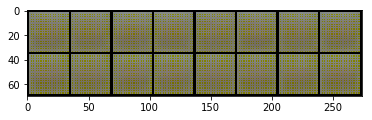

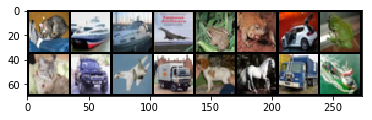

In [15]:
print(o.max(),o.min())
imshow(torchvision.utils.make_grid(o.cpu().detach()))
pylab.show()
imshow(torchvision.utils.make_grid(images))
pylab.show()

(3, 70, 274)


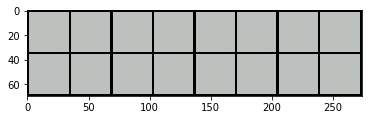

In [64]:
img = o /2 + 0.5
img = torchvision.utils.make_grid(img)
npimg = img.detach().numpy()
print (npimg.shape)
c = np.transpose(npimg, (1, 2, 0))
plt.imshow(c, cmap= plt.cm.gray)

In [82]:
torch.sigmoid(torch.Tensor([1]))

tensor([0.7311])

In [105]:
print (reconstruction_function(o.to(device), torch.sigmoid(images.to(device))))

tensor(13.5574, device='cuda:1', grad_fn=<BinaryCrossEntropyBackward>)


In [107]:
images.min()

tensor(-1.)

In [6]:
model.device

AttributeError: 'VAE' object has no attribute 'device'

In [20]:
images.size()

AttributeError: 'torch.Size' object has no attribute 'sum'